In [26]:
import numba
import numpy as np
import pandas as pd
import missingno  as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from numba import jit
from IPython.display import Image
from IPython.core.display import HTML 

import ipywidgets as widgets

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [19]:
print(numba.__version__)

0.53.1


In [29]:
df = pd.read_csv('macapa-2000-2020.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.rename( columns = { 'chuva' : 'precipitacao' })
df.head()

,data,hora,temperatura,umidade,pressao,vel_vento,direcao_vento,nebulosidade,insolacao,temp_max,temp_min,precipitacao
0,2000-01-01,12.0,27.2,80.0,1006.8,1.0,32.0,10.0,6.854922,32.108248,24.000000,0.000000
1,2000-01-01,18.0,29.6,64.0,1006.1,2.0,9.0,10.0,6.854922,32.108248,24.121414,6.919249
2,2000-01-02,0.0,25.6,89.0,1005.6,0.0,0.0,10.0,7.200000,30.800000,24.121414,6.919249
3,2000-01-02,12.0,25.2,90.0,1006.7,0.0,0.0,10.0,6.854922,32.108248,24.000000,53.500000
4,2000-01-02,18.0,30.2,68.0,1004.3,2.0,5.0,6.0,6.854922,32.108248,24.121414,6.919249


# Criando Variaveis Sazonais

In [17]:
df['data'] = pd.to_datetime(df['data'])

df["diadasemana"] = df["data"].dt.dayofweek
df["diadomes"] = df["data"].dt.day
df["trimestre"] = df["data"].dt.quarter
df["mes"] = df["data"].dt.month
df["semanadoano"] = df["data"].dt.weekofyear
df["ano"] = df["data"].dt.year

df.head()

,data,hora,temperatura,umidade,pressao,vel_vento,direcao_vento,nebulosidade,insolacao,temp_max,temp_min,precipitacao,diadasemana,diadomes,trimestre,mes,semanadoano,ano
0,2000-01-01,12.0,27.2,80.0,1006.8,1.0,32.0,10.0,6.854922,32.108248,24.000000,0.000000,5,1,1,1,52,2000
1,2000-01-01,18.0,29.6,64.0,1006.1,2.0,9.0,10.0,6.854922,32.108248,24.121414,6.919249,5,1,1,1,52,2000
2,2000-01-02,0.0,25.6,89.0,1005.6,0.0,0.0,10.0,7.200000,30.800000,24.121414,6.919249,6,2,1,1,52,2000
3,2000-01-02,12.0,25.2,90.0,1006.7,0.0,0.0,10.0,6.854922,32.108248,24.000000,53.500000,6,2,1,1,52,2000
4,2000-01-02,18.0,30.2,68.0,1004.3,2.0,5.0,6.0,6.854922,32.108248,24.121414,6.919249,6,2,1,1,52,2000


# Atrasos (lags) da série temporal

**LAG = Yt - 1**

Mudando a série [Math Processing Error] para trás, obtemos uma feature em que o valor atual da série temporal está alinhado com seu valor no tempo [Math Processing Error]. Se fizermos uma mudança de 1 lag e treinarmos um modelo com essa nova feature, o modelo poderá prever um passo à frente e observar o estado atual da série. Aumentar o atraso (lag), digamos, até 7, permitirá que o modelo faça previsões 28 passos à frente; no entanto, usará os dados observados nas 28 etapas para trás. Se algo mudar fundamentalmente a série durante esse período não observado, o modelo não capturará essas alterações e retornará previsões com um grande erro. Portanto, durante a seleção do atraso inicial, é preciso encontrar um equilíbrio entre a qualidade ideal da previsão e a duração de previsão.

In [31]:
for l in range(1, 7):
    df[f'lag_{l}'] = df['precipitacao'].shift(l)

# Diferença dos Lag 

**DIFF_LAG = Yt-1 - Yt-2**

In [25]:
for l in range(1, 7):
    df[f'diff_lag_{l}'] = df['precipitacao'].diff(l)

In [26]:
df.columns

Index(['data', 'hora', 'temperatura', 'umidade', 'pressao', 'vel_vento',
       'direcao_vento', 'nebulosidade', 'insolacao', 'temp_max', 'temp_min',
       'precipitacao', 'diadasemana', 'diadomes', 'trimestre', 'mes',
       'semanadoano', 'ano', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4',
       'diff_lag_5', 'diff_lag_6'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23029 entries, 0 to 23028
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           23029 non-null  datetime64[ns]
 1   hora           23029 non-null  float64       
 2   temperatura    23029 non-null  float64       
 3   umidade        23029 non-null  float64       
 4   pressao        23029 non-null  float64       
 5   vel_vento      23029 non-null  float64       
 6   direcao_vento  23029 non-null  float64       
 7   nebulosidade   23029 non-null  float64       
 8   insolacao      23029 non-null  float64       
 9   temp_max       23029 non-null  float64       
 10  temp_min       23029 non-null  float64       
 11  precipitacao   23029 non-null  float64       
 12  diadasemana    23029 non-null  int64         
 13  diadomes       23029 non-null  int64         
 14  trimestre      23029 non-null  int64         
 15  mes            2302

In [28]:
df.select_dtypes(include=np.number).columns

Index(['hora', 'temperatura', 'umidade', 'pressao', 'vel_vento',
       'direcao_vento', 'nebulosidade', 'insolacao', 'temp_max', 'temp_min',
       'precipitacao', 'diadasemana', 'diadomes', 'trimestre', 'mes',
       'semanadoano', 'ano', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4',
       'diff_lag_5', 'diff_lag_6'],
      dtype='object')

# Split

In [29]:
y = pd.DataFrame(df['precipitacao'])
x = pd.DataFrame(df[['hora','temperatura', 'umidade', 'pressao', 'vel_vento',
                    'direcao_vento', 'nebulosidade', 'insolacao', 'temp_max', 
                    'temp_min', 'diadasemana', 'diadomes', 'trimestre', 'mes',
                    'semanadoano', 'ano', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                    'lag_6', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4',
                    'diff_lag_5', 'diff_lag_6']])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = None, shuffle = False)
X_treino, X_val, y_treino, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = None, shuffle = False)

print(X_train.shape, X_test.shape, df.shape )
print(X_treino.shape, X_val.shape, y_val.shape )

X_treino = pd.DataFrame(X_treino)
X_val = pd.DataFrame(X_val)
y_treino = pd.DataFrame(y_treino)
y_val = pd.DataFrame(y_val)

(18423, 28) (4606, 28) (23029, 30)
(14738, 28) (3685, 28) (3685, 1)


In [30]:
# Dados normalizados 
x_norm = pd.DataFrame(x - np.min(x) )/(np.max(x) - np.min(x))
y_norm = pd.DataFrame(y - np.min(y) )/(np.max(y) - np.min(y))

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(x_norm, y_norm, test_size=0.2, random_state = 42)
X_treino_norm, X_val_norm, y_treino_norm, y_val_norm = train_test_split(X_train_norm, y_train_norm, test_size=0.2, random_state = 42)

# XGBOOST

In [31]:
xgbr = xgb.XGBRegressor(n_estimators=100)

xgbr.fit(X_treino_norm, y_treino_norm, eval_set = [(X_treino_norm, y_treino_norm),
                                                  (X_val_norm, y_val_norm)], 
                                                   early_stopping_rounds=50, 
                                                   verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred_xgbr = xgbr.predict(X_val_norm)

### Avaliando o modelo 

1. Função Score do Sklearn quanto mais proximo de 1.0 melhor!

Podemos aplicar essa mesma função no nosso conjunto de teste — com dados que o modelo nunca viu na vida — , tipo assim: modelo.score(X_test, Y_test) . Desse jeito, o modelo irá comparar o valor que ele previu com o valor que era esperado no conjunto de test.É muito importante que seu modelo não tenha um score absurdamente alto no conjunto de treino, enquanto no de teste ele está bem baixo. Quando isso acontece, você está enfrentando um problema de Overfitting

In [33]:
xgbr.score(X_treino_norm, y_treino_norm)

0.9999200484743483

In [34]:
xgbr.score(X_val_norm, y_val_norm)

0.9836350516514961

2. **RMSE**  Raiz Quadrada do Erro Quadrático Médio
A diferença entre o valor que foi previsto pelo seu modelo e o valor real que foi observado.

<p align="center">
    <img src="https://miro.medium.com/max/700/0*OVJBC2cPGcol6Wu8.png"/>
</p>    

In [35]:
RMSE = np.sqrt(mean_squared_error(y_val_norm, y_pred_xgbr))
print(f'RMSE: {RMSE}')

RMSE: 0.005090460029785655


4. **K-Fold**

Agora você converterá o conjunto de dados em uma estrutura de dados otimizada chamada Dmatrixque o XGBoost suporta e oferece ganhos de desempenho e eficiência aclamados.

Desta vez, você criará um dicionário de hiperparâmetro paramsque contém todos os hiperparâmetros e seus valores como pares de valores-chave, mas excluirá o n_estimatorsdo dicionário de hiperparâmetro porque você usará em seu num_boost_roundslugar.

Você usará esses parâmetros para construir um modelo de validação cruzada de 3 partes invocando o cv()método do XGBoost e armazenar os resultados em um cv_resultsDataFrame. Observe que aqui você está usando o objeto Dmatrix que criou antes.

In [36]:
# Convertendo o conjunto de dados em uma estrutura de dados otimizada chamada Dmatrix o XGBoost suporta e oferece ganhos de desempenho e eficiência
data_dmatrix = xgb.DMatrix(data=x ,label=y)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=50, 
                    metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: ../src/objective/regression_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.339768,0.061239,9.332490,0.584121
1,8.487008,0.162129,8.484745,0.563087
2,7.688184,0.179194,7.688345,0.511508
3,7.032727,0.178025,7.052317,0.564827
4,6.369865,0.168745,6.388934,0.522631


In [37]:
# Extraia e imprima a métrica final da rodada de reforço.
print((cv_results["test-rmse-mean"]).tail(1)) 

49    0.526534
Name: test-rmse-mean, dtype: float64


4. **Visualize árvores de reforço**

Você também pode visualizar árvores individuais a partir do modelo totalmente otimizado que o XGBoost cria usando todo o conjunto de dados. O XGBoost possui uma plot_tree()função que facilita esse tipo de visualização. Depois de treinar um modelo usando a API de aprendizado XGBoost, você pode passá-lo para a plot_tree()função junto com o número de árvores que deseja plotar usando o argumento num_trees

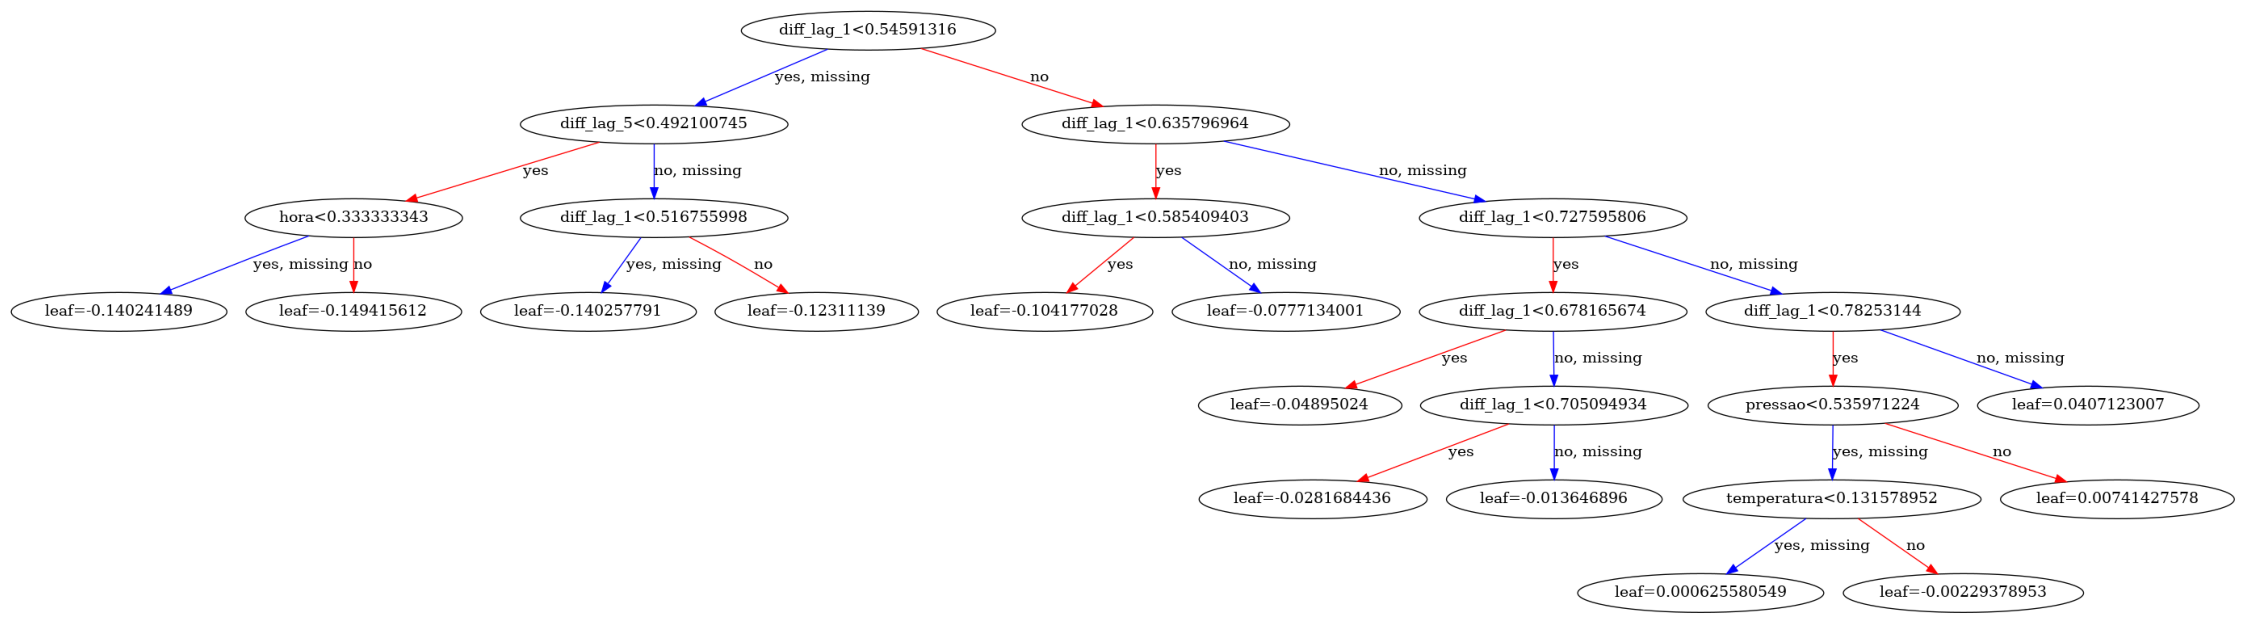

In [38]:
xgb.plot_tree(xgbr, num_trees=0)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

5. **Plot das Features mais importantes**

Outra maneira de visualizar seus modelos XGBoost é examinar a importância de cada coluna de recurso no conjunto de dados original dentro do modelo.

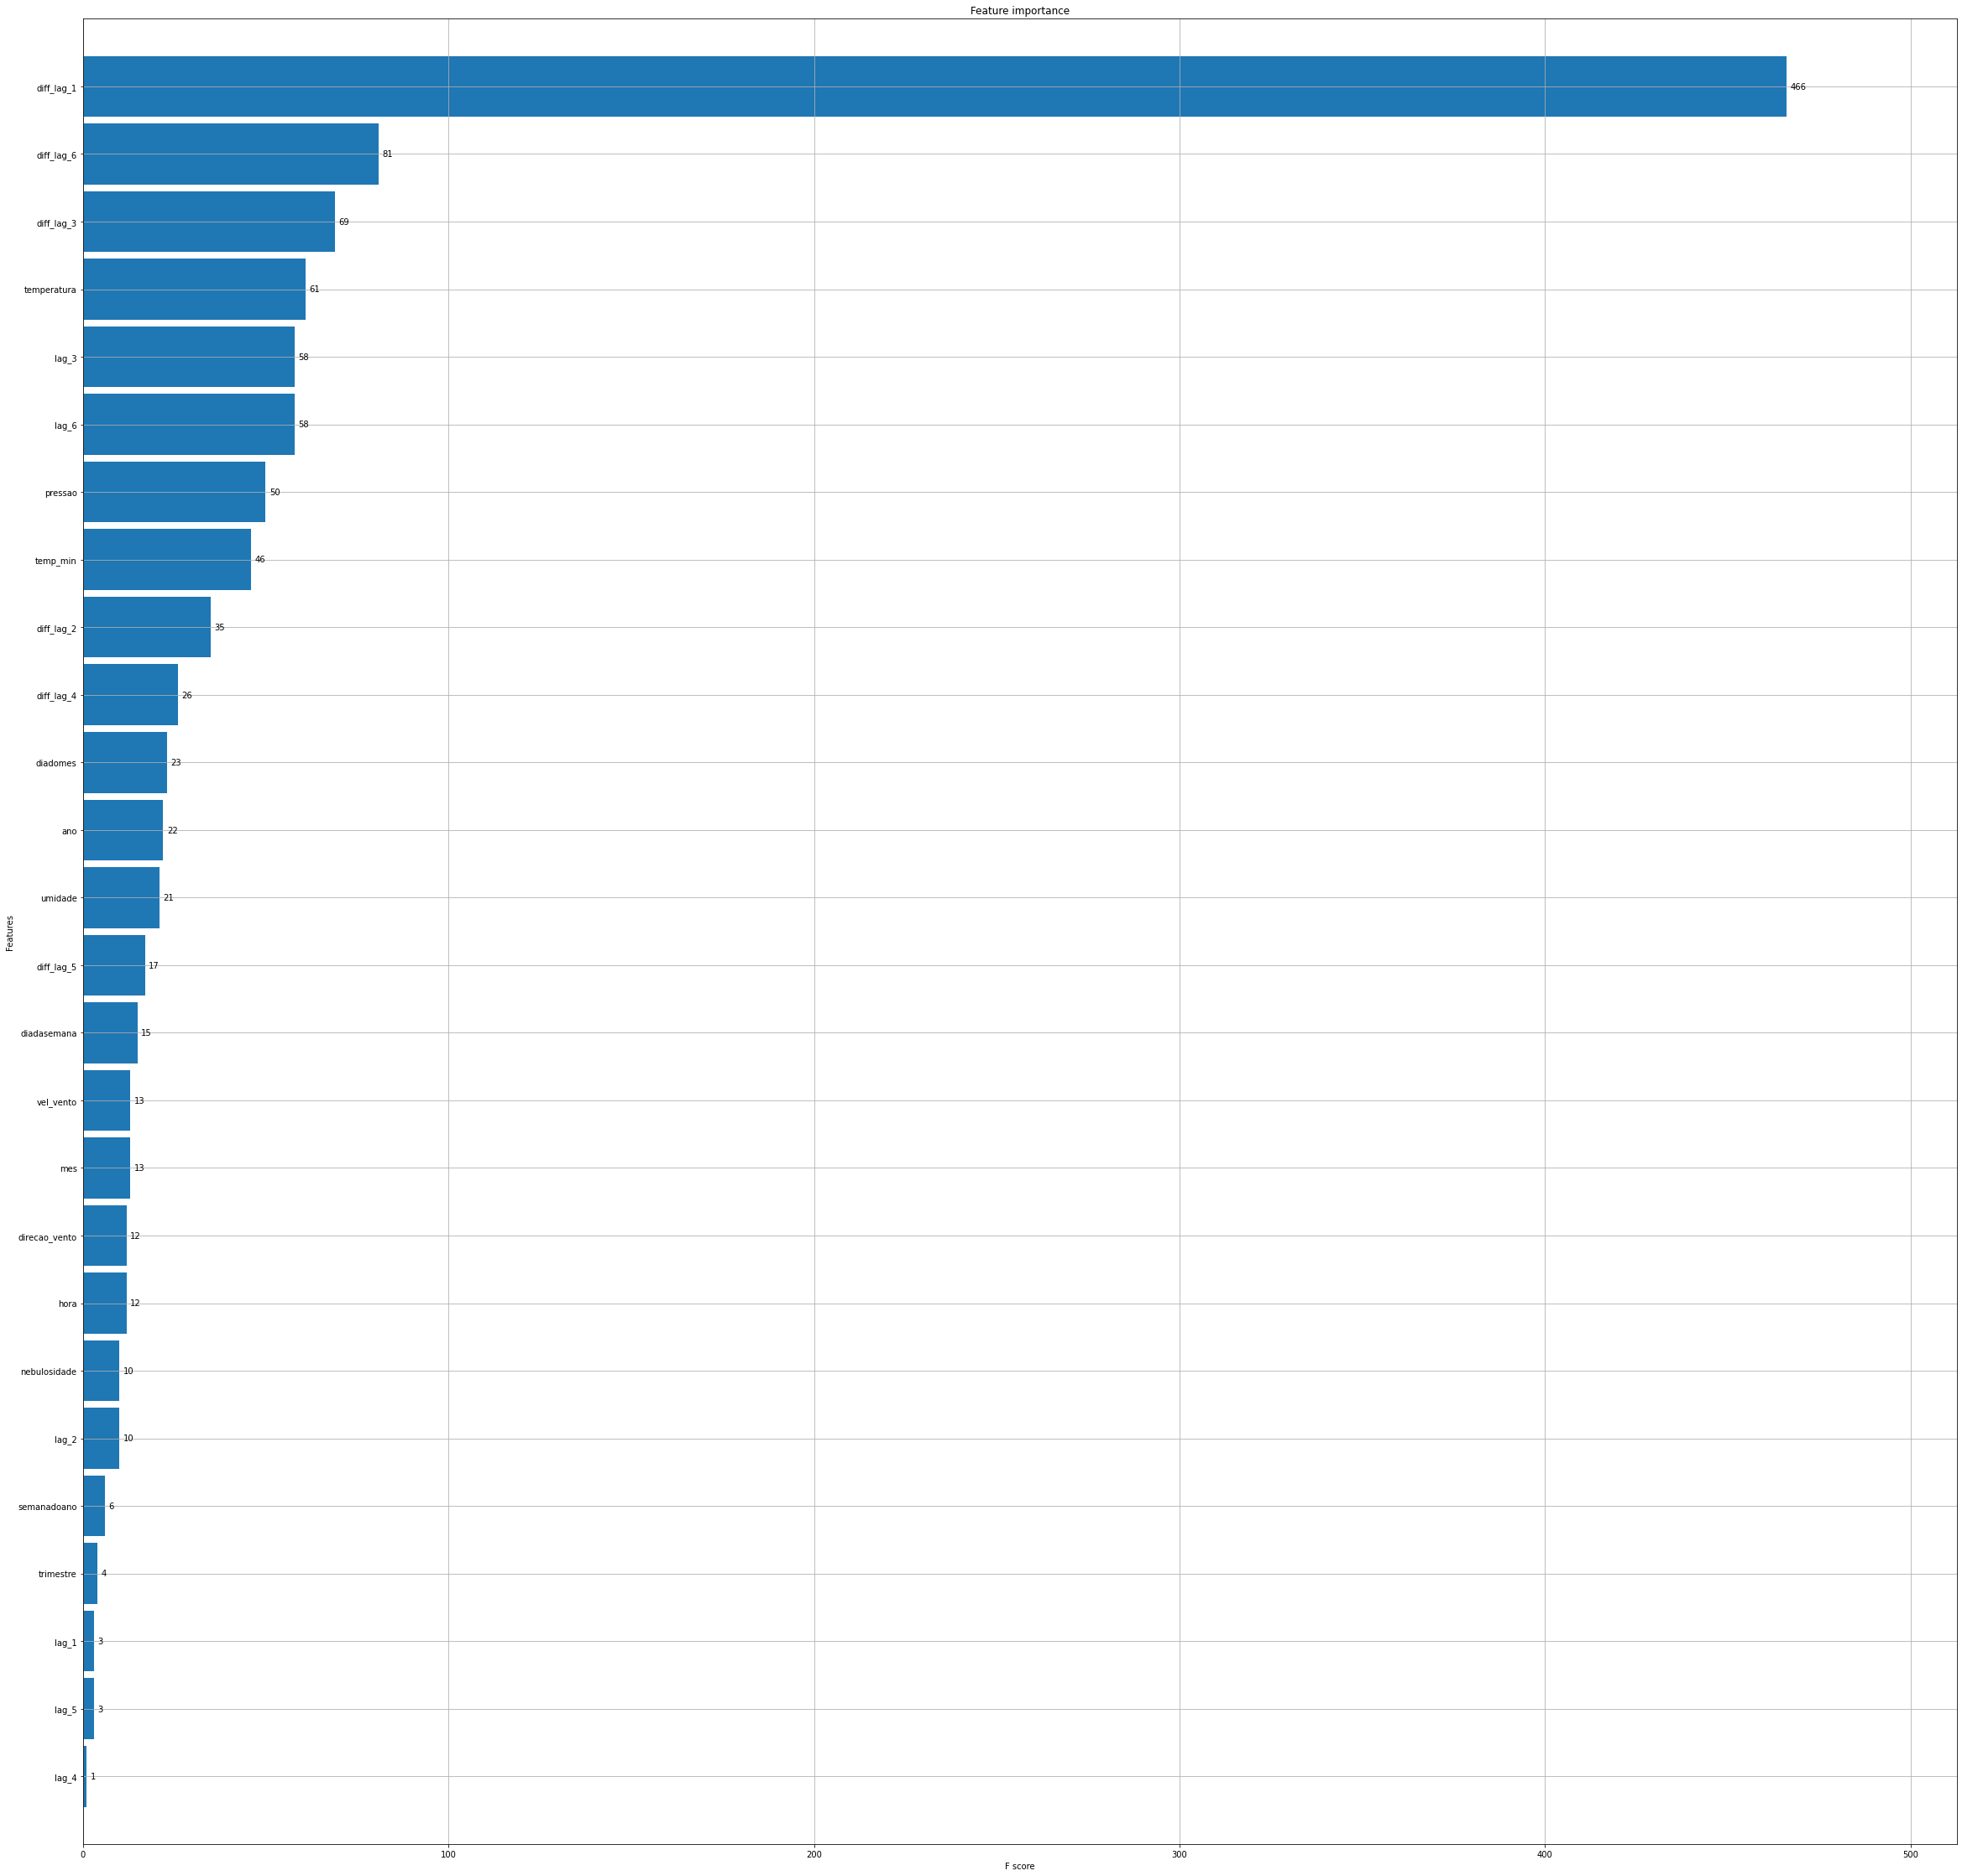

In [39]:
xgb.plot_importance(xgbr, height = 0.9)
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

# LITHGBM

In [40]:
lgbm = LGBMRegressor(n_jobs=-1, random_state=0, n_estimators=100, 
                        learning_rate=0.001, num_leaves=2**6, 
                        subsample=0.9, subsample_freq=1,
                        colsample_bytree=1.)

lgbm.fit(X_treino_norm, y_treino_norm) 
y_pred_lgbm = lgbm.predict(X_val_norm)

1. **Score**

In [41]:
lgbm.score(X_treino_norm, y_treino_norm)

0.17859230346423094

In [42]:
lgbm.score(X_val_norm, y_val_norm)

0.16690703113340954

2. **RMSE**

In [43]:
RMSE = np.sqrt(mean_squared_error(y_val_norm, y_pred_lgbm))
print(f'RMSE: {RMSE}')

0.036320050761728895

# CATBOOST

In [44]:
cat = CatBoostRegressor(loss_function='RMSE', depth=3, learning_rate=0.4, iterations=1000, 
    random_seed=18, 
    od_type='Iter',
    od_wait=20,
)

cat.fit(
    X_treino_norm, y_treino_norm, use_best_model=True,
    eval_set=(X_val_norm, y_val_norm),
    verbose=False,  
    plot=True,
)

y_pred_cat = cat.predict(X_val_norm)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1. **Score**

In [45]:
cat.score(X_val_norm, y_val_norm)

-6983.275259235879

In [46]:
cat.score(X_treino_norm, y_treino_norm)

-29421.907579028222

2. **RMSE**

In [47]:
RMSE = np.sqrt(mean_squared_error(y_val_norm, y_pred_cat))
print(f'RMSE: {RMSE}')

0.0073661180760505535

# Random Forest

In [48]:
X_treino_norm_rf = X_treino_norm.fillna(X_treino_norm.mean())

rf = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=1000, min_samples_leaf=200, max_features='auto')
rf.fit(X_treino_norm_rf, y_treino_norm) 

y_pred_rf = rf.predict(X_val_norm)

1. **Score**

In [49]:
rf.score(X_treino_norm_rf, y_treino_norm)

0.8216177995010938

In [50]:
rf.score(X_val_norm, y_val_norm)

0.7736702717608404

2. **RMSE**

In [51]:
RMSE = np.sqrt(mean_squared_error(y_val_norm, y_pred_rf))
print(f'RMSE: {RMSE}')

0.018930867388323273